In [1]:
from load.load_data import load_opendata
from load.load_data import load_mydata

import matplotlib.pyplot as plt
%matplotlib inline
import random

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import model.model_autoencoder
from model.model_autoencoder import model_autoencoder
from tensorflow.keras.models import load_model

import os
import numpy as np
from utils.process import preprocess, noise, augment, tsne_plot, display_pair, shuffler

In [2]:
# Intialize the tensorflow-gpu <-> physical matching
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
openloader = load_opendata()
X_open, Y_open = openloader.load_data(classifier_label=None, dsize=(64,64), comp_ratio=4)

myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=10, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4, verbose=0)

print("Open data is ", len(X_open),", My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

Test opendata without Label: 100%|██████████| 79726/79726 [01:55<00:00, 691.08it/s]
Train data Loading with OOP: 24821it [00:09, 2741.22it/s]
Test data Loading with OOP: 2000it [00:03, 628.73it/s]

Open data is  19932 , My Train set is  1014 ,  My Test set is  340


In [4]:
# Normalized Image
X = preprocess(X_open, shape = (64,64,3))

# Data Augmentation (5%*3=15%)
X = augment(X, ratio=0.05)

# Shuffled Image
X = shuffler(X)

# Noise Image
Noise_X = noise(X)

Augmentation samples are 2988


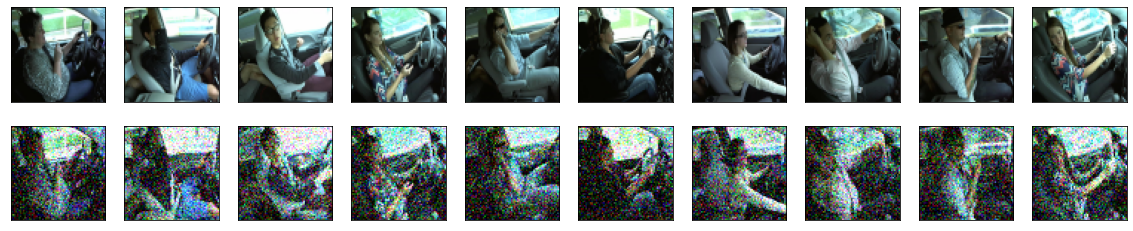

(22920, 64, 64, 3) (22920, 64, 64, 3)


In [5]:
display_pair(X,Noise_X)

In [6]:
# Train, Val, Test Split
X_train = X[:int(len(X)*0.9)]
X_val = X[int(len(X)*0.9):]

print(X_train.shape)
print(X_val.shape)

(20628, 64, 64, 3)
(2292, 64, 64, 3)


In [ ]:
def scheduler(epoch, lr):
    if epoch in [13,15,25,28]:
        lr = 0.1*lr
    return lr
    
autoencoder = model_autoencoder(input_shape = (64, 64, 3))
adam = Adam(learning_rate=0.001)
ls_callback = LearningRateScheduler(scheduler)
es_callback = EarlyStopping(monitor='val_loss', patience=3)
filepath = os.path.join(os.getcwd(), "ckpt/", "Autoencoder_-{epoch:01d}-{val_loss:.2f}.h5")
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

autoencoder.compile(loss = 'mse', optimizer = adam)
autoencoder.summary()

In [ ]:
autoencoder.fit(x=X_train, y = X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_val, X_val), callbacks=[ls_callback, es_callback, checkpoint])

In [ ]:
# Save Model
autoencoder.save('./ckpt/model_autoencoder')

In [ ]:
# Display the train data and a version of it with added noise
sample_X = np.array(Noise_X)
sample_X = X_val[10:100]

#predictions = autoencoder.predict(Noise_X[int(len(Noise_X)*0.9):])
predictions = autoencoder.predict(sample_X)

In [ ]:
display_pair(sample_X, predictions)

## Load and Test autoencoder

In [11]:
# model_auto = load_model("./ckpt/Autoencoder_fine-30-0.04.h5")
model_auto = load_model("./ckpt/model_autoencoder")

In [12]:
model_auto.trainable=False
model_auto.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
enc_1st_conv (Conv2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
enc_1st_relu (ReLU)          (None, 64, 64, 64)        0         
_________________________________________________________________
enc_1st_maxpool (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
enc_2nd_conv (Conv2D)        (None, 32, 32, 128)       204928    
_________________________________________________________________
enc_2nd_relu (ReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
enc_2nd_maxpool (MaxPooling2 (None, 16, 16, 128)       0     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

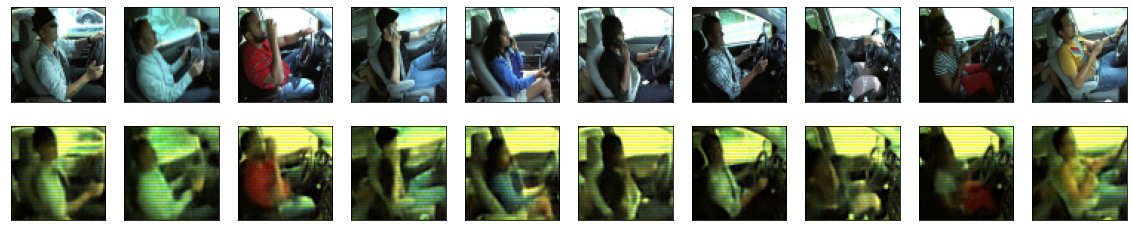

(100, 64, 64, 3) (100, 64, 64, 3)


In [17]:
prediction= model_auto.predict(X_val[0:100])
display_pair(X_val[0:100],prediction)